In [1]:
# Import libraries
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''<style>.jupyter-matplotlib {background-color: #000;}.widget-label, .jupyter-matplotlib-header{color: #fff;}.jupyter-button {background-color: #333;color: #fff;}</style>''')

In [3]:
# Specify headers
cv_names = {'subjects',
            'Preoperative Off-Medicine',
            'Preoperative On-Medicine',
            'Postoperative Off-Medicine &Off-Stimulation\n',
            'Postoperative  Off-Medicine &On-Stimulation'}
# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_proc.csv'
motor_df = util.filter_data(file_dir,cv_names,filter_data=False)
# Find cases with all required scores
cv_names = motor_df.columns[:-1]
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['subjects']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/chh/batch/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/chh/batch/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/chh_rois.csv'
n_cases = len(os.listdir(npy_dir+'X/'))
n_rois = 6
n_features = 1316
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,n_features,all_rois)
ids = np.asarray(ID_all).astype(int)
per_change = ((cv_dict['Preoperative Off-Medicine']-cv_dict['Postoperative  Off-Medicine &On-Stimulation'])/cv_dict['Preoperative Off-Medicine'])[np.in1d(subs,ids)]
pre_updrs = cv_dict['Preoperative Off-Medicine'][np.in1d(subs,ids)]
subsc = subs[np.in1d(subs,ids)]
X_all_c = X_all.reshape(n_cases,n_rois,n_features)
K_all_c = K_all.reshape(n_cases,n_rois,n_features)
R_all_c = R_all.reshape(n_cases,n_rois,n_features)

Index(['subjects', 'LCT ', 'Preoperative Off-Medicine',
       'Preoperative On-Medicine',
       'Postoperative  Off-Medicine &Off-Stimulation\n ',
       'Postoperative  Off-Medicine &On-Stimulation'],
      dtype='object')
['01', '02', '03', '05', '06', '07', '08', '09', '10', '11', '13', '14', '16', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']
Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


In [4]:
viz_raw = False
if viz_raw == True:
    for j in np.arange(n_cases):
        plt.figure()
        plt.imshow(X_all_c[j,0,:].reshape(28,-1))
        plt.title('Subject '+str(j))
        plt.show
sc = skp.StandardScaler()
X0_ss0 = sc.fit_transform(np.append(X_all_c.reshape(n_cases,-1),pre_updrs.reshape(-1,1),axis=1))
K = np.append(K_all_c.reshape(n_cases,-1),np.asarray(len(pre_updrs)*['pre_updrs']).reshape(-1,1),axis=1)

original_shape_Maximum2DDiameter 0.475 0.47471
original_shape_Sphericity -0.517 -0.51745
original_gldm_LargeDependenceHig -0.438 -0.43793
exponential_glrlm_RunLengthNonUn 0.44 0.43995
square_glrlm_RunLengthNonUniform 0.441 0.4411
wavelet-HHL_glcm_Correlation -0.437 -0.43709
logarithm_gldm_LargeDependenceLo -0.414 -0.41426
squareroot_gldm_DependenceVarian 0.396 0.39561
wavelet-LLH_gldm_LargeDependence 0.403 0.40297
wavelet-LLH_glrlm_LongRunEmphasi 0.417 0.41706
wavelet-LLH_glrlm_RunLengthNonUn -0.401 -0.40096
wavelet-LLH_glrlm_RunPercentage -0.401 -0.4014
wavelet-LLH_glrlm_RunVariance 0.405 0.40451
wavelet-LLH_glrlm_ShortRunEmphas -0.405 -0.40511
wavelet-LHL_firstorder_90Percent -0.436 -0.43619
wavelet-LHL_firstorder_Kurtosis 0.459 0.45873
wavelet-LHL_firstorder_RobustMea -0.405 -0.40536
wavelet-LHL_glcm_Idn 0.459 0.4588
wavelet-LHL_gldm_DependenceNonUn -0.434 -0.43404
wavelet-LHL_gldm_DependenceVaria 0.458 0.45846
wavelet-LHL_gldm_GrayLevelNonUni 0.427 0.42659
wavelet-LHL_gldm_LargeDep

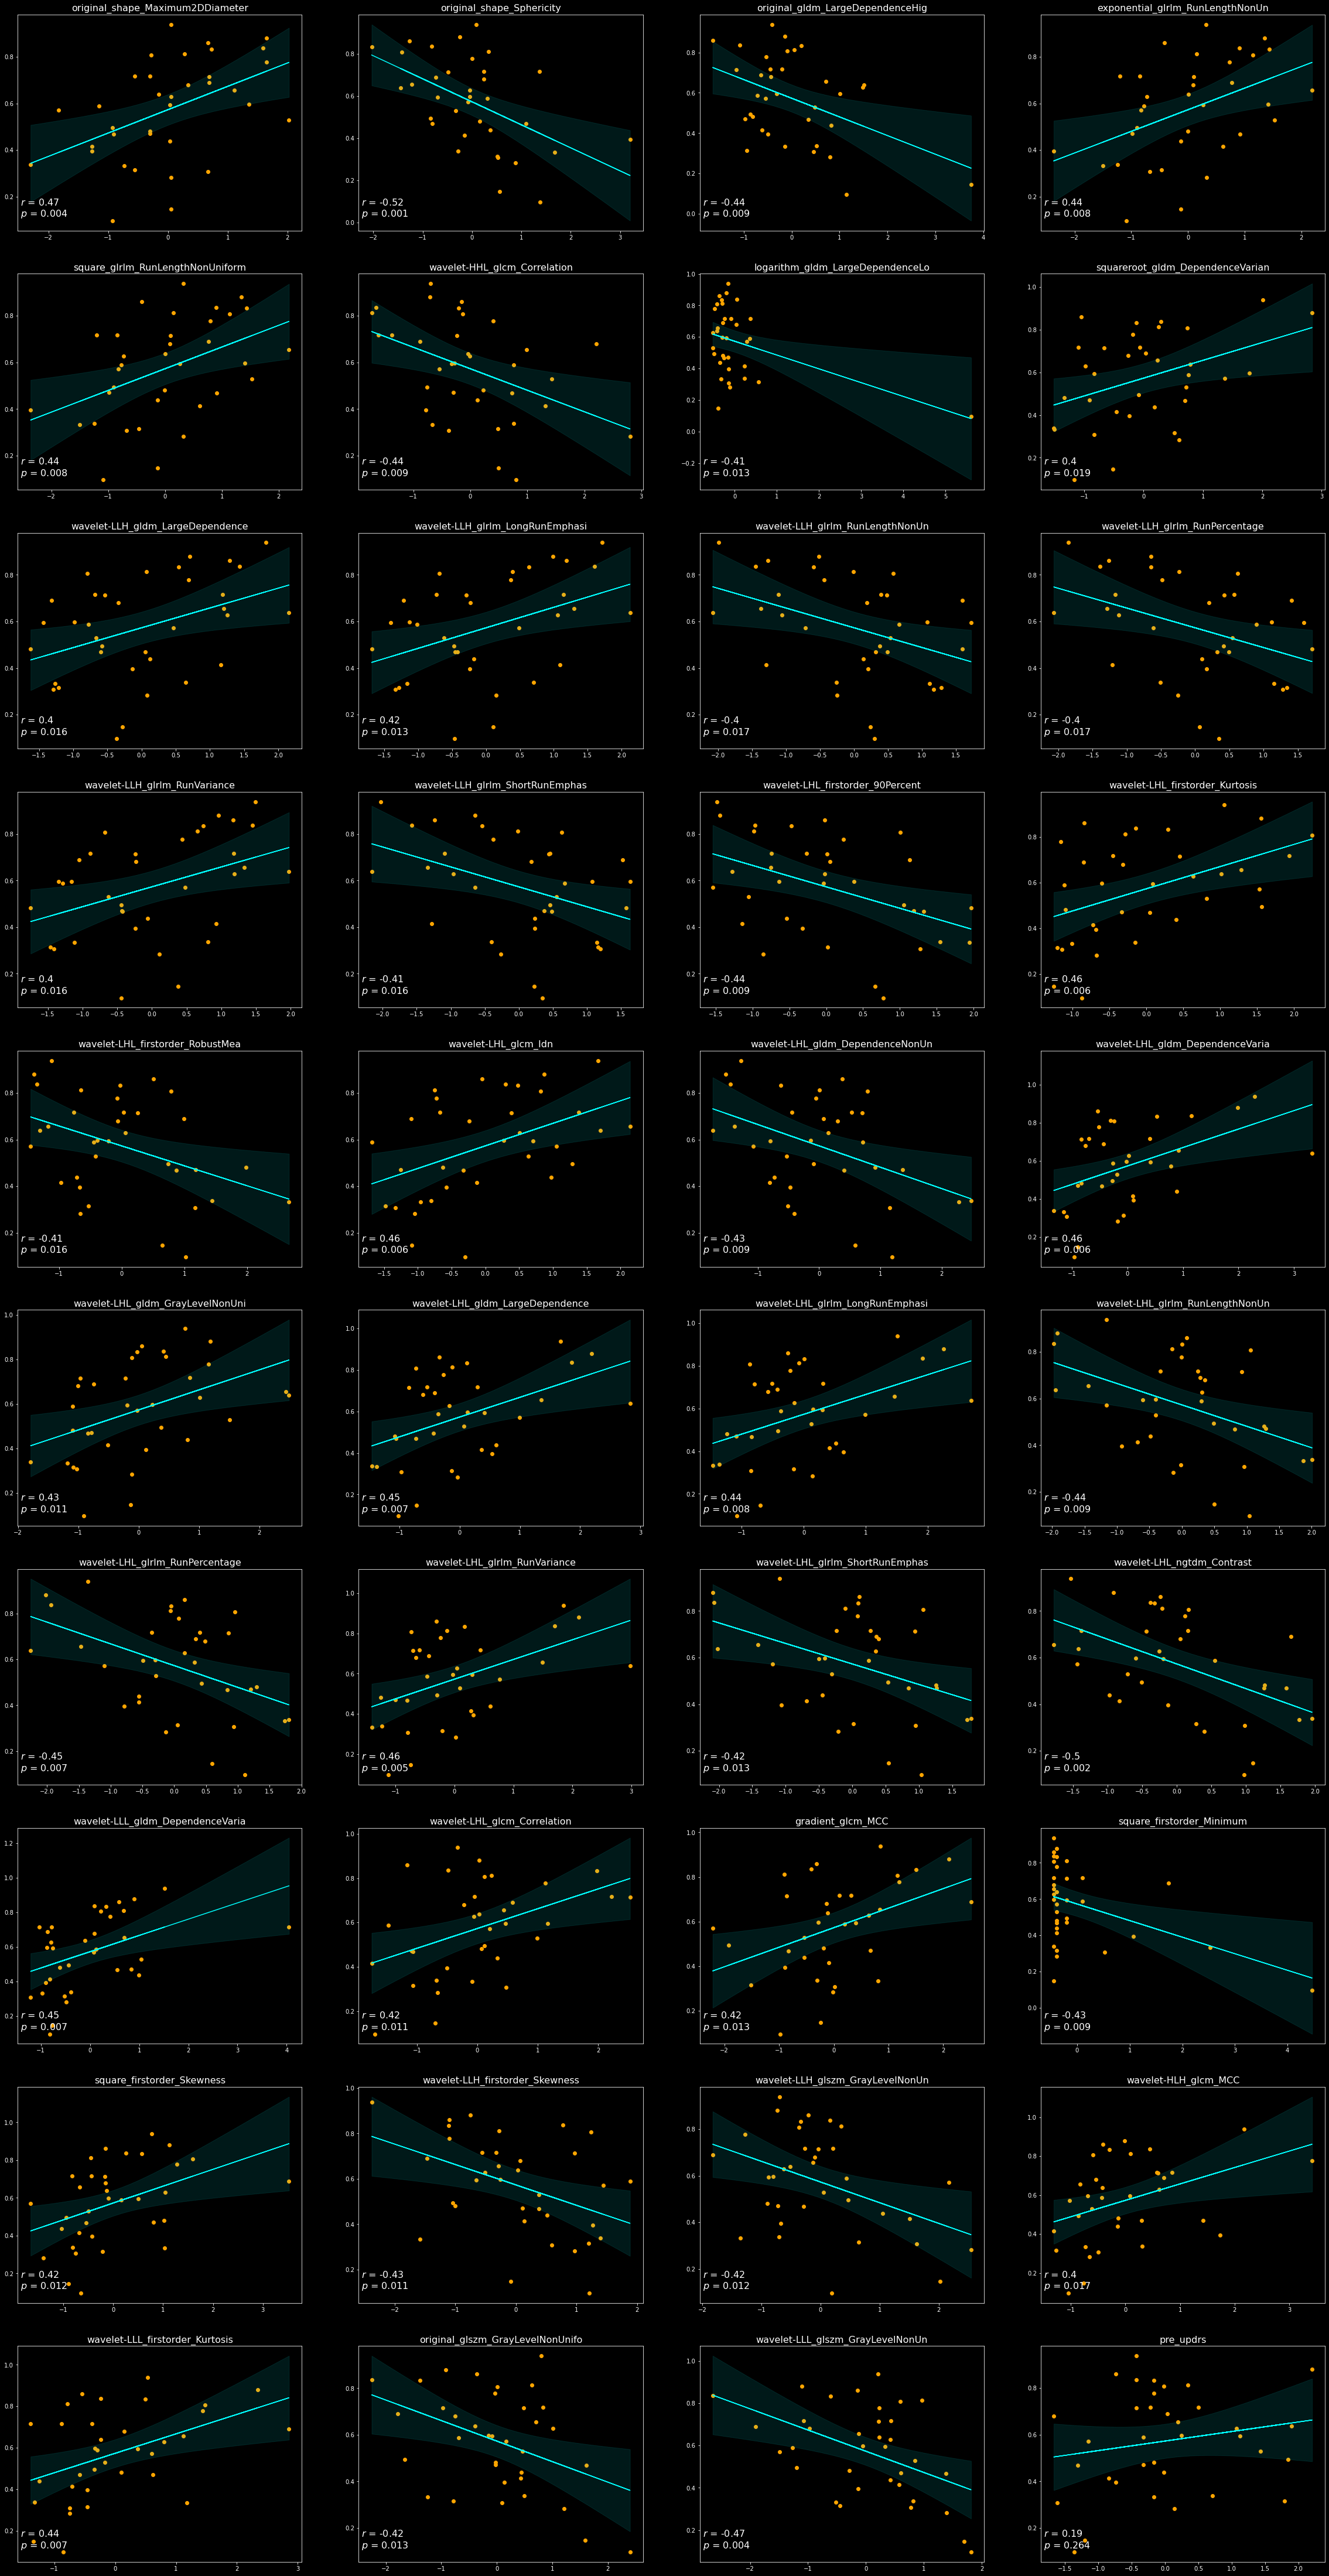

In [31]:
rcParams['figure.figsize'] = 40, 80
Lr = []
Lp = []
pc = 0
v = 0
nps = 40
rw = 10
viz = True
c = 0
with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
# Feature selection
  for k in np.arange(X0_ss0.shape[1]):
    lr = stats.linregress(X0_ss0[:,k],per_change)
    if (abs(lr.rvalue)>0.35 and lr.pvalue < 0.02):
        Lr.append(lr.rvalue)
        Lp.append(lr.pvalue)
        print(K[0][k],np.round(Lr[c],3),np.round(Lr[c],5))
        c = c+1
    if pc < nps:
      if (abs(lr.rvalue)>0.35 and lr.pvalue < 0.02):
        if pc < nps-1:
          next
        else:
          k = -1
          lr = stats.linregress(X0_ss0[:,k],per_change)
          print(K[k],np.round(lr.rvalue,3),np.round(lr.pvalue,5))
        y_model = X0_ss0[:,k]*lr.slope+lr.intercept
        if viz == True:
          v = v+1
          ax = plt.subplot(rw,nps//rw,v)
          ax.scatter(X0_ss0[:,k],per_change,color='orange')
          ax.plot(X0_ss0[:,k],y_model,color='cyan') 

        x = X0_ss0[:,k]
        y = per_change
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        # number of samples
        n = x.size   
        # number of parameters: slope and intercept                     
        m = 2     
        # degrees of freedom                       
        dof = n-m  
        # statistic of interval confidence                       
        t = stats.t.ppf(0.975,dof)  
        # Standard deviation of the error
        residual_ut = y-y_model
        std_error = (np.sum(residual_ut**2)/dof)**(1/2)

        # Pearson's correlation coefficient
        numerator = np.sum((x-x_mean)*(y-y_mean))
        denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**(1/2)
        correlation_coef = numerator/denominator
        r = correlation_coef
        tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
        # p-value for 2-sided test
        pv = 2*(1-stats.t.cdf(abs(tr), dof))
        # mean squared error
        MSE = 1/n*np.sum((y-y_model)**2)
    
  
        x_line = np.linspace(np.min(x),np.max(x),len(x))
        y_line = x_line*lr.slope+lr.intercept
        ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**(1/2)
        ax.set_title(K[0][k],fontsize=16)
        ax.fill_between(x_line,y_line+ci,y_line-ci,color = 'cyan',label = '95% confidence interval',alpha=0.1)
        ax.text(0.01,0.05,'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(round(lr.pvalue,3)),
                ha='left', va='bottom', transform=ax.transAxes,fontsize=16)   
        plt.style.use('dark_background')
        pc = pc+1

print('Repeat for each N-1 training dataset')



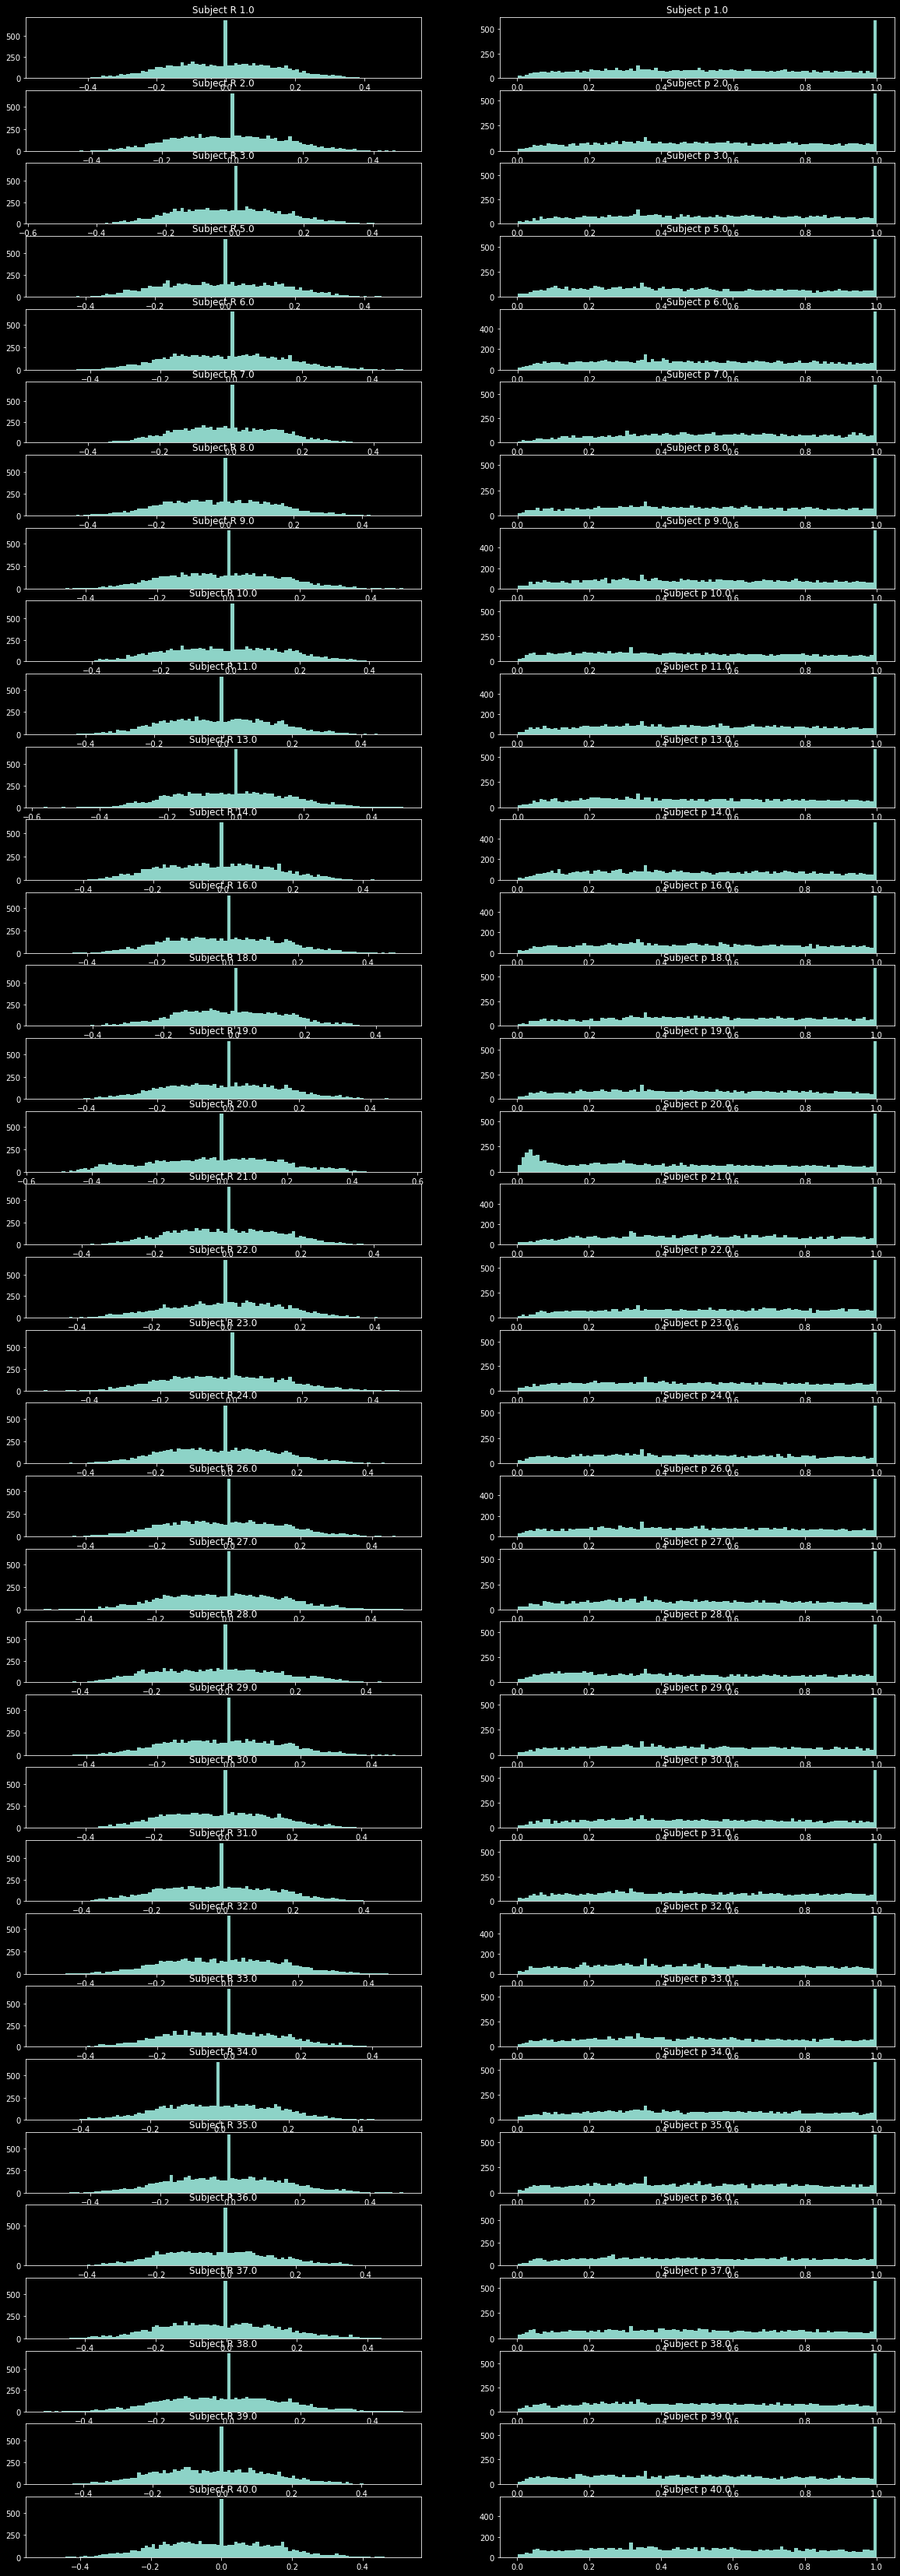

In [30]:
rcParams['figure.figsize'] = 20, 60
rcParams['figure.max_open_warning'] = False
fig, ax = plt.subplots(n_cases,2)
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    Lr = []
    Lp = []
    idy = np.where(y_cat==1)
    # Cross validation
    X0_sst,scaler_ss,X_test_sst = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,
                                                None,None,None,None,None,None,None,None,None,
                                                False,False,False)
    for k in np.arange(X0_sst.shape[1]):
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
            lr = stats.linregress(X0_sst[:,k],y_train)
            Lr.append(lr.rvalue)
            Lp.append(lr.pvalue)

    ax[j][0].hist(np.asarray(Lr), bins=100)
    ax[j][1].hist(np.asarray(Lp), bins=100)
    ax[j][0].set_title('Subject R '+str(subsc[j]))
    ax[j][1].set_title('Subject p '+str(subsc[j]))

plt.show()